In [57]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import playbyplay,leaguegamefinder,leaguedashteamstats
from nba_api.stats.static import teams
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep
from tqdm.notebook import tqdm
pd.options.display.max_columns = None
from scipy import stats
from fitter import Fitter
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import flexcode
from flexcode.regression_models import XGBoost
from xgboost import XGBRegressor
import optuna


In [2]:
all_runs_to = pd.read_csv('all_runs_to_2023-24.csv')

In [3]:
all_runs_to['gp'] = all_runs_to['gp'].astype(str)

In [4]:
all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('4')==False]
all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('5')==False]
all_runs_to.reset_index(drop=True,inplace=True)

In [5]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] + 10

In [6]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] + 10

In [7]:
all_runs_to['scoring_ratio'] = (((all_runs_to['home_score']-all_runs_to['previous_run_home_score']) -(all_runs_to['away_score']-all_runs_to['previous_run_away_score'])) /all_runs_to['time_spent_run']).fillna(0)

In [8]:
# Loop through window sizes from 2 to 5 for backward-looking averages
for i in range(2, 6):
    all_runs_to[f'avg_{i}_scoring_ratio'] = (
        all_runs_to.groupby('gp')['scoring_ratio']
        .rolling(window=i, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Create shifted columns for forward-looking sums
for shift in range(1, 6):
    all_runs_to[f'shift_-{shift}_scoring_ratio'] = all_runs_to.groupby('gp')['scoring_ratio'].shift(-shift)

# Calculate the forward-looking averages for the next 1 to 5 runs
for i in range(1, 6):
    # Forward-looking average for 'scoring_ratio'
    all_runs_to[f'next_{i}_avg_scoring_ratio'] = (
        sum(all_runs_to[f'shift_-{shift}_scoring_ratio'] for shift in range(1, i+1)) / i
    ).fillna(method='ffill')

# Drop the intermediate shifted columns if no longer needed
all_runs_to.drop(columns=[f'shift_-{shift}_scoring_ratio' for shift in range(1, 6)], inplace=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_13900\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_13900\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_13900\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_13900\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_13900\4017142516.py:19: FutureWarning: Serie

In [9]:
all_runs_to['run_length_continued'] = all_runs_to['run_length'] - (all_runs_to['to_index'] + 1)

In [10]:
df_analysis = all_runs_to.copy()

In [11]:
model_cols = [x for x in df_analysis.columns if 'next' not in x and 'scoring_ratio' in x]
model_cols_2 = ['avg_opponent_run_length', 'opponent_run_length_max',
       'opponent_run_length_min', 'avg_own_run_length', 'own_run_length_max',
       'own_run_length_min', 'net_diff','next_3_avg_scoring_ratio','previous_run_time', 'last_run_time', 'time_spent_run', 'to_time']
model_cols = model_cols + model_cols_2

In [12]:
to_df = df_analysis[(df_analysis['to_non_run']==1)][model_cols]

In [13]:
X = to_df.drop('next_3_avg_scoring_ratio',axis=1)

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)

In [15]:
pca_components_df = pd.DataFrame(pca_components,columns=['PC1','PC2','PC3'])
pca_components_df['home_to'] = df_analysis[(df_analysis['to_non_run']==1)]['home_to'].values

In [16]:
pca_components_df['next_3_avg_scoring_ratio'] = df_analysis[(df_analysis['to_non_run']==1)]['next_3_avg_scoring_ratio'].values

In [17]:
X_train,X_test,y_train,y_test =  train_test_split(pca_components_df.drop('next_3_avg_scoring_ratio',axis=1),
                                                  pca_components_df['next_3_avg_scoring_ratio'],random_state=42)

In [ ]:
# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    max_basis = trial.suggest_int('max_basis', 30, 70)
    basis_system = trial.suggest_categorical('basis_system', ['cosine'])
    
    n_estimators = trial.suggest_int('n_estimators', 10, 1500)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1,log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    
    # Parameterize the model with the suggested hyperparameters
    model = flexcode.FlexCodeModel(
        XGBoost,
        max_basis=max_basis,
        basis_system=basis_system,
        regression_params={
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth
        }
    )
    
    # Fit the model
    model.fit(X_train.values, y_train.values)
    
    # Evaluate the model
    cde_loss = np.abs(model.estimate_error(X_test.values, y_test.values, n_grid=1000))
    
    return cde_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = flexcode.FlexCodeModel(
    XGBoost,
    max_basis=best_params['max_basis'],
    basis_system=best_params['basis_system'],
    regression_params={
        'n_estimators': best_params['n_estimators'],
        'learning_rate': best_params['learning_rate'],
        'max_depth': best_params['max_depth']
    }
)
final_model.fit(X_train.values, y_train.values)

# Evaluate the final model
final_cde_loss = final_model.estimate_error(X_test.values, y_test.values, n_grid=1000)
print("Final Model CDE Loss: ", final_cde_loss)

In [ ]:
{'max_basis': 68, 'basis_system': 'cosine', 'n_estimators': 499, 'learning_rate': 0.09978082774194517, 'max_depth': 10}

Average Log-Likelihood: -0.32862157953660187
RMSE for Conditional Mean: 0.05549503556260016
RMSE for Conditional Standard Deviation: 0.09122680736668978


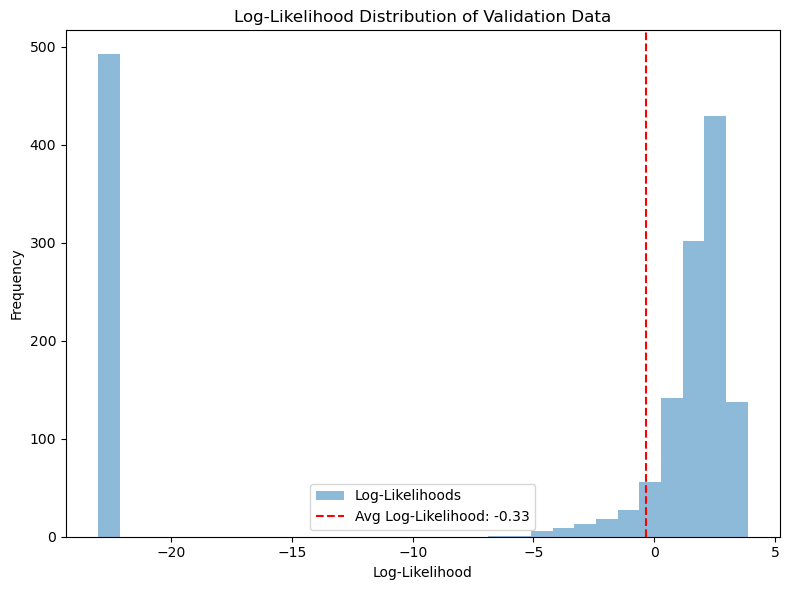

In [61]:
# Parameterize and fit the FlexCode model
model = flexcode.FlexCodeModel(XGBoost, max_basis=68, basis_system="cosine",
                               regression_params={'n_estimators': 499, 'learning_rate': 0.09, 'max_depth': 10})
model.fit(X_train.values, y_train.values)

#Predict conditional densities and y grid using the model for validation set
cdes, y_grid_flexcode = model.predict(X_test.values, n_grid=1000)
y_grid_flexcode = y_grid_flexcode.reshape(-1)

# Define function to calculate the expectation (mean) and standard deviation of the estimated distribution
def conditional_mean_std(cde, y_grid):
    mean_est = np.sum(y_grid * cde) / np.sum(cde)  # Mean as the weighted average
    std_est = np.sqrt(np.sum(((y_grid - mean_est) ** 2) * cde) / np.sum(cde))  # Std deviation
    return mean_est, std_est

# Calculate metrics
log_likelihoods = []
rmse_means = []
rmse_stds = []

epsilon = 1e-10  # Small value to avoid log(0)

# Iterate over validation set
for i in range(len(X_test)):
    y_value = y_test.values[i]
    cde = cdes[i]
    
    # Calculate conditional mean and standard deviation for the estimated distribution
    mean_est, std_est = conditional_mean_std(cde, y_grid_flexcode)
    
    # Calculate log-likelihood with epsilon to avoid log(0)
    interpolated_density = np.interp(y_value, y_grid_flexcode, cde, left=0, right=0) + epsilon
    log_likelihood = np.log(interpolated_density)
    log_likelihoods.append(log_likelihood)
    
    # Calculate RMSE for mean
    rmse_mean = (y_value - mean_est) ** 2
    rmse_means.append(rmse_mean)
    
    # Calculate RMSE for standard deviation
    rmse_std = ((abs(y_value - mean_est) - std_est) ** 2)
    rmse_stds.append(rmse_std)

# Average log-likelihood
avg_log_likelihood = model.estimate_error(X_test.values, y_test.values)

# RMSE for mean
rmse_mean = np.sqrt(np.mean(rmse_means))

# RMSE for standard deviation
rmse_std = np.sqrt(np.mean(rmse_stds))

print("Average Log-Likelihood:", avg_log_likelihood)
print("RMSE for Conditional Mean:", rmse_mean)
print("RMSE for Conditional Standard Deviation:", rmse_std)

# Plotting the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(log_likelihoods, bins=30, alpha=0.5, label='Log-Likelihoods')
ax.axvline(avg_log_likelihood, color='r', linestyle='--', label=f'Avg Log-Likelihood: {avg_log_likelihood:.2f}')
ax.set_title("Log-Likelihood Distribution of Validation Data")
ax.set_xlabel("Log-Likelihood")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()
#-0.0969059333619775

c:\Users\isaac\.conda\envs\timeout_analysis\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
crystalball,5.458627,1472.131128,1498.117457,inf,0.019256,0.052220
norm,7.372443,3294.858458,3307.851622,inf,0.031258,0.000136
pearson3,7.377283,3124.683794,3144.173540,inf,0.031615,0.000109
lognorm,7.378784,3329.503320,3348.993067,inf,0.031485,0.000119
t,9.231891,1013.272280,1032.762026,inf,0.026162,0.002406


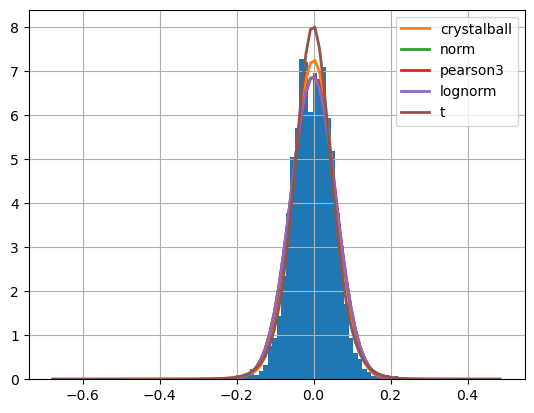

In [94]:
f = Fitter(y_train.values,distributions=['crystalball','expon','gamma','lognorm','norm','pearson3','triang','uniform','weibull_min','weibull_max',
                                         'logistic','t'])
f.fit()
f.summary()

In [62]:
cdes, y_grid_flexcode = model.predict(X_test.values, n_grid=1000)

In [63]:
# Function to calculate the conditional mean (expected value)
def conditional_mean(cde, y_grid):
    mean_est = np.round(np.sum(y_grid * cde) / np.sum(cde),4)  # Mean as the weighted average
    return mean_est

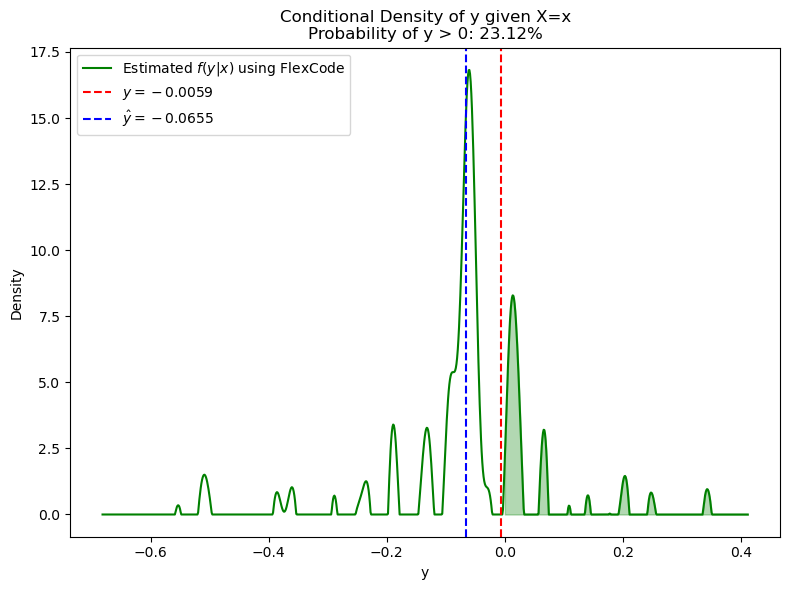

In [162]:
# Define the range for y values based on your data
y_grid_refined = np.linspace(y_train.min(), y_train.max(), 1000)

# Plotting setup
fig, ax = plt.subplots(figsize=(8, 6))
beta, m = 1, 2

# Iterate over a few random samples for visualization
for c, sample_index in enumerate(np.random.RandomState().choice(len(X_test), size=1, replace=False)):
    y_value = np.round(y_test.values[sample_index], 4)
    
    # Calculate PDF of crystalball distribution for the given y_value
    pdf_logistic = stats.crystalball.pdf(y_grid_refined, loc=y_value, scale=0.02, beta=beta, m=m)
    cde = cdes[sample_index]
    
    # Calculate Q1 and Q3
    q1 = np.percentile(cde, 25)
    q3 = np.percentile(cde, 75)
    
    # Plot real conditional density (logistic distribution)
    # ax.plot(y_grid_refined, pdf_logistic, "--", color=f"blue", label=f"Real $f(y | x = {y_value})$ Logistic")
    
    # Plot estimated CDE using FlexCode model
    ax.plot(y_grid_flexcode, cde, color=f"green", label=f"Estimated $f(y | x)$ using FlexCode")
    
    # Shade the area where y > 0 for the FlexCode model CDE
    ax.fill_between(y_grid_flexcode, 0, cde, where=(y_grid_flexcode > 0), color=f"green", alpha=0.3)
    #ax.fill_between(y_grid_flexcode, 0, cde, where=(cde >= q1) & (cde <= q3), color="green", alpha=0.3, label=f"Q1-Q3 range {q1} - {q3} ")
    
    # Highlight the actual y value with a vertical line
    ax.axvline(y_value, color="red", linestyle="--", label=f"$y = {y_value}$")
    
    # Calculate conditional mean
    y_hat = conditional_mean(cde, y_grid_flexcode)
    
    # Highlight the conditional mean y_hat with a vertical line
    ax.axvline(y_hat, color="blue", linestyle="--", label=rf"$\hat{{y}} = {y_hat}$")
    
    # Calculate positive probability
    cde_df = pd.DataFrame([cde, y_grid_flexcode]).T
    cde_df.columns = ['cde', 'y_grid_flexcode']
    positive_prob = np.round((cde_df[(cde_df['cde'] > 0) & (cde_df['y_grid_flexcode'] > 0)]['cde'].sum() / 1000) * 100, 2)

# Set plot labels and title
ax.set_title("Conditional Density of y given X=x\n" + f"Probability of y > 0: {positive_prob}%")
ax.set_xlabel("y")
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()

In [69]:
def objective(trial):
    # Suggest hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e-1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e-1),
    }

    # Initialize and train the model
    xgb = XGBRegressor(**param)
    xgb.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb.predict(X_test)

    # Calculate RMSE as the evaluation metric
    rmse = mean_squared_error(y_test, y_pred)
    return rmse

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)  # Run for 50 trials or 10 minutes

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
final_xgb = XGBRegressor(**best_params)
final_xgb.fit(X_train, y_train)

# Evaluate the final model
final_y_pred = final_xgb.predict(X_test)
final_rmse = mean_squared_error(y_test, final_y_pred)
final_r2 = r2_score(y_test, final_y_pred)
print("Final Model RMSE: ", final_rmse)

[I 2024-07-09 17:26:50,083] A new study created in memory with name: no-name-12a9b0c4-0099-43be-8ec9-7d32a79cf57c
C:\Users\isaac\AppData\Local\Temp\ipykernel_13900\27649211.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\isaac\AppData\Local\Temp\ipykernel_13900\27649211.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e-1),
C:\Users\isaac\AppData\Local\Temp\ipykernel_13900\27649211.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

Best hyperparameters:  {'n_estimators': 673, 'learning_rate': 0.05683160253721207, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.008981176435332971, 'subsample': 0.9455516763606688, 'colsample_bytree': 0.6387957979307444, 'reg_alpha': 0.05386094862930195, 'reg_lambda': 0.04542952890757108}
Final Model RMSE:  0.0022069920382482315


In [70]:
best_params = {'n_estimators': 673, 'learning_rate': 0.05683160253721207, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.008981176435332971, 'subsample': 0.9455516763606688, 'colsample_bytree': 0.6387957979307444, 'reg_alpha': 0.05386094862930195, 'reg_lambda': 0.04542952890757108}
xgb = XGBRegressor(**best_params)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6387957979307444, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.008981176435332971,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05683160253721207,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=673, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [71]:
mean_squared_error(y_test,xgb.predict(X_test))

np.float64(0.0022069920382482315)

In [80]:
to_df['to_team'] = df_analysis[(df_analysis['to']==1)&(df_analysis['to_non_run']==1)]['to_team'].values

In [86]:
pca_df = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2','PC3'])
pca_df['home_to'] = df_analysis[(df_analysis['to']==1)&(df_analysis['to_non_run']==1)]['home_to'].values

In [88]:
to_df['exp_3_scoring_ratio'] = xgb.predict(pca_df.values)

In [92]:
to_df['difference_3_scoring_ratio'] = np.abs(to_df['next_3_avg_scoring_ratio'] - to_df['exp_3_scoring_ratio'])

<Axes: xlabel='to_team'>

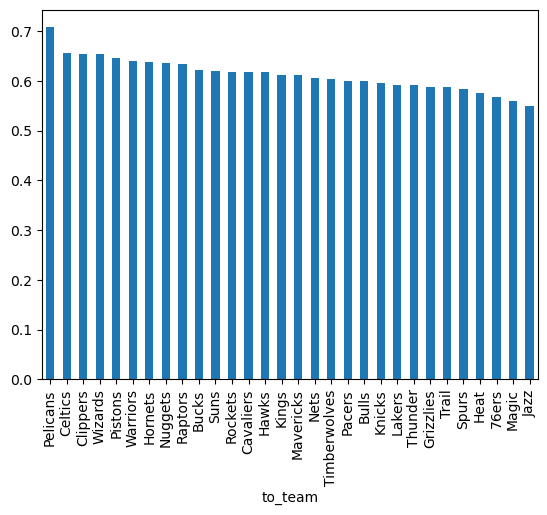

In [104]:
(to_df[to_df['exp_3_scoring_ratio']>0].groupby('to_team').size()/to_df.groupby('to_team').size()).sort_values(ascending=False).plot(kind='bar')